In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

In [2]:
gpus = tf.config.list_physical_devices(device_type = 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
class DataLoader:
    def __init__(self):
        AS_dataset = pd.read_csv('./Arbitrary_Single_band_Coupler_Phase_Shift.csv', encoding='utf-8')
        self.X = AS_dataset.loc[:,'freq':'L4'].to_numpy()
        self.y = AS_dataset.loc[:,'S11r':'S41i'].to_numpy()
#         self.mmX = MinMaxScaler()
#         self.X[:,1:] = self.mmX.fit_transform(self.X[:,1:])
#         self.X[:,0] = self.X[:,0] / 10
#         self.X, _, self.y, _ = train_test_split(self.X, self.y, test_size=0.75, random_state=0)
        self.X_train, self.X_vali, self.y_train, self.y_vali = train_test_split(self.X, self.y, test_size=0.1, random_state=0)
        self.num_train = self.X_train.shape[0]
    def get_batch(self, batch_size=0, mode='train'):
        if mode == 'train':
            index = np.random.randint(0, self.num_train, batch_size)
            return self.X_train[index], self.y_train[index]
        if mode == 'validate':
            return self.X_vali, self.y_vali

In [4]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(units=1024, activation=tf.nn.leaky_relu)
        self.dense3 = tf.keras.layers.Dense(units=512, activation=tf.nn.leaky_relu)
        self.dense4 = tf.keras.layers.Dense(units=256, activation=tf.nn.leaky_relu)
        self.dense5 = tf.keras.layers.Dense(units=8)
    
#     @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        output = self.dense5(x)
        return output

In [5]:
num_epochs = 200
batch_size = 256
learning_rate = 0.001

In [6]:
model = MLP()
data_loader = DataLoader()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
X_v, y_v = data_loader.get_batch(mode='validate')

epoch:0
train mse:0.07971172034740448 rmse:0.2823326289653778 mae:0.22627681493759155 r2:0.3395746946334839
vali mse:0.08474166691303253 rmse:0.2911042273044586 mae:0.23591430485248566 r2:0.29751110076904297
epoch:10
train mse:0.05938107892870903 rmse:0.24368232488632202 mae:0.19229696691036224 r2:0.5109015703201294
vali mse:0.06228772923350334 rmse:0.24957509338855743 mae:0.19780655205249786 r2:0.4836490750312805
epoch:20
train mse:0.04238978773355484 rmse:0.2058878093957901 mae:0.16073426604270935 r2:0.6480401158332825
vali mse:0.04187386855483055 rmse:0.204631045460701 mae:0.1603894978761673 r2:0.6528753042221069
epoch:30
train mse:0.03867433965206146 rmse:0.1966579258441925 mae:0.1506367027759552 r2:0.6810166835784912
vali mse:0.037626124918460846 rmse:0.1939745396375656 mae:0.15130570530891418 r2:0.688088059425354
epoch:40
train mse:0.03341212868690491 rmse:0.1827898472547531 mae:0.14228472113609314 r2:0.7243889570236206
vali mse:0.032903820276260376 rmse:0.18139410018920898 mae:0

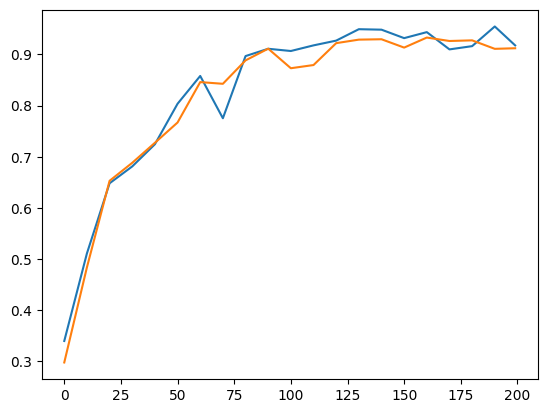

In [7]:
showX = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 199]
showY1 = []
showY2 = []

num_batch = data_loader.num_train // batch_size
for epoch_index in range(num_epochs):
    for batch in range(num_batch):
        X, y = data_loader.get_batch(batch_size)
        with tf.GradientTape() as tape:
            y_pred = model(X)
            tr_mse = tf.reduce_mean(tf.square(y_pred - y))
        grads = tape.gradient(tr_mse, model.variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
    if epoch_index % 10 == 0 or epoch_index == num_epochs - 1:
        tr_rmse = tf.sqrt(tr_mse)
        tr_mae = tf.reduce_mean(tf.abs(y_pred - y))
        tr_r2 = 1 - tf.reduce_sum(tf.square(y_pred - y)) / tf.reduce_sum(tf.square(y - tf.cast(tf.reduce_mean(y), dtype=tf.float32)))
        print("epoch:{}".format(epoch_index))
        print("train mse:{} rmse:{} mae:{} r2:{}".format(tr_mse, tr_rmse, tr_mae, tr_r2))
        y_v_p = model(X_v)
        va_mse = tf.reduce_mean(tf.square(y_v_p - y_v))
        va_rmse = tf.sqrt(va_mse)
        va_mae = tf.reduce_mean(tf.abs(y_v_p - y_v))
        va_r2 = 1 - tf.reduce_sum(tf.square(y_v_p - y_v)) / tf.reduce_sum(tf.square(y_v - tf.cast(tf.reduce_mean(y_v), dtype=tf.float32)))
        print("vali mse:{} rmse:{} mae:{} r2:{}".format(va_mse, va_rmse, va_mae, va_r2))
        showY1.append(tr_r2)
        showY2.append(va_r2)
plt.plot(showX, showY1, showX, showY2)
plt.show()

In [9]:
tf.saved_model.save(model, './models')

INFO:tensorflow:Assets written to: ./models/assets


In [14]:
model = tf.saved_model.load('./models')

In [ ]:
def dgn_obj(s_para):
    E = tf.square(s_para)
    E11 = E[:,0] + E[:,1]
    E21 = E[:,2] + E[:,3]
    E31 = E[:,4] + E[:,5]
    E41 = E[:,6] + E[:,7]
    l1 = E11 - E21 - E31 + E41
    l2 = tf.abs(E21 / (E31 + E21) - 0.61)
    l3 = tf.abs(tf.math.atan2(s_para[:,5], s_para[:,4]) - tf.math.atan2(s_para[:,3], s_para[:,2]) - np.pi / 4)
    l4 = tf.abs(tf.reduce_sum(E, axis=1) - 1)
    loss = l1 + l2 + l3 + l4
    return loss

In [28]:
def loss_func(s1, s2, s3):
    var = tf.reduce_sum(tf.nn.moments(tf.concat([s1, s2, s3], axis=0), [0])[1][2: 6])
    return var + dgn_obj(s1) + dgn_obj(s2) + dgn_obj(s3)

In [30]:
num_nodes = 5000
num_node_epochs = 500

In [31]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

mmin = np.min(data_loader.X[: , 1: ], axis=0)
mmax = np.max(data_loader.X[: , 1: ], axis=0)

# structure.append(tf.Variable(np.random.uniform(0, 1, (num_nodes, 10)), dtype=tf.float32))
structure = tf.Variable(np.random.uniform(mmin, mmax, (num_nodes, 12)), dtype=tf.float32)

freq1 = tf.ones([num_nodes, 1]) * 2.4
freq2 = tf.ones([num_nodes, 1]) * 2.5
freq3 = tf.ones([num_nodes, 1]) * 2.6

minLoss = 0
minIndex = 0
minS = 0

In [32]:
bestLoss = 10
bestStructure = 0

In [33]:
def check(structure):
    inva_place1 = tf.where(tf.logical_or(structure[:,:8] < 1, structure[:,:8] > 4))
    structure = tf.tensor_scatter_nd_update(structure, [inva_place1], [np.random.uniform(mmin[inva_place1[:,1]], mmax[inva_place1[:,1]], (inva_place1.shape[0]))])
    
    inva_place2 = tf.where(tf.logical_or(structure[:,8:] < 4, structure[:,8:] > 100)) + [0, 8]
    structure = tf.tensor_scatter_nd_update(structure, [inva_place2], [np.random.uniform(mmin[inva_place2[:,1]], mmax[inva_place2[:,1]], (inva_place2.shape[0]))])
    
    return tf.Variable(structure)
    
    # structure[j] = tf.Variable(tf.tensor_scatter_nd_update(structure[j], [nega_place], [np.random.uniform(0, 1, (nega_place.shape[0]))]))

In [34]:
for i in range(num_node_epochs):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(structure)
        y_pred1 = model(tf.concat([freq1, structure], axis=1))
        y_pred2 = model(tf.concat([freq2, structure], axis=1))
        y_pred3 = model(tf.concat([freq3, structure], axis=1))
        loss = loss_func(y_pred1, y_pred2, y_pred3)
    minLoss = tf.reduce_min(loss).numpy()
    minIndex = tf.argmin(loss).numpy()
    minS = structure[minIndex].numpy()
    grads = tape.gradient(loss, structure)
    opt.apply_gradients(grads_and_vars=zip([grads], [structure]))
    structure = check(structure)
    if minLoss < bestLoss:
        bestLoss = minLoss
        bestStructure = minS
        # bestStructure = data_loader.mmX.inverse_transform([minS[0]])[0]
        print(minIndex)
        print(i, bestLoss)
        print(bestStructure)
        print()

3720
0 -0.7943266
[ 2.3792987  3.521848   1.3430307  4.531899   3.4642618  1.8280202
  2.8326237  2.6676188 60.676464  81.957214  68.15542   17.210348 ]

2124
1 -1.5447816
[ 4.2131944  1.7722692  1.020481   4.309943   2.627635   2.5053978
  1.0017825  2.91659   52.562214  85.40346   59.875317  25.120247 ]

2124
2 -1.7340338
[ 4.8194213  1.7797107  1.0130397  3.2727354  2.6201937  2.5128384
  1.0092238  2.9240313 52.554775  85.4109    59.88276   25.112806 ]

988
3 -1.9712064
[ 2.500336   2.7885072  1.7813797  2.434511   3.9723752  3.1722305
  2.4207182  2.9231663 18.05391   10.056872  61.532845  62.29775  ]

988
4 -1.9853035
[ 2.5061471  2.7943184  1.7755684  2.4287     3.9781864  3.1780417
  2.414907   2.9173615 18.059721  10.062682  61.527042  62.30356  ]

988
5 -1.9985778
[ 2.511602   2.7997732  1.7701135  2.4232452  3.9836411  3.1834965
  2.4094522  2.922813  18.065176  10.068136  61.52159   62.309013 ]

988
6 -2.0111506
[ 2.5168228  2.8049943  1.7648923  2.4180243  3.9888623  3.188